In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import os
import xlrd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


In [3]:
import warnings

# Suppress the SettingWithCopyWarning warnings
warnings.filterwarnings('ignore')

# Your existing code here

# Reset the warning filters
warnings.resetwarnings()


In [4]:
def plot_mutations_per_position(df):
    # Print number of NA
    print(f'Number of NA: {df["variant"].isna().sum()}')
    # Print number of WT
    if "WT" in df["variant"].unique():
        print(f'Number of WT: {df["variant"].value_counts()["WT"]}')
    else:
        print('WT not found in mutation column')
    # Filter out rows with missing or "WT" mutations
    df_filtered = df.dropna(subset=["variant"]).query('variant != "WT"')

    # Initialize an empty dictionary to store the number of mutations per position
    mutations_per_position = {}
    
    # Print the size of the dataset
    print(f'Number of variants: {len(df_filtered)}')

    # Print the number of fitness_binary = 1 values
    print(f'Number of fitness_binary = 1: {len(df_filtered.query("fitness_binary == 1"))}')

    # Iterate over the rows of the DataFrame and increment the count of mutations at each position
    for mutation_str in df_filtered["variant"]:
        # Remove the initial and final characters from the mutation string
        pos = int(mutation_str[1:-1])

        # Increment the count of mutations at this position in the dictionary
        if pos in mutations_per_position:
            mutations_per_position[pos] += 1
        else:
            mutations_per_position[pos] = 1

    # Plot a histogram of the number of mutations per position
    plt.bar(mutations_per_position.keys(), mutations_per_position.values())
    plt.xlabel('Number of mutations')
    plt.ylabel('Number of positions')
    plt.title('Mutations per position')
    plt.show()

In [5]:
def plot_histogram_of_readout(df, column_name):
    # Plot histogram of readout values for all mutants
    fig, ax = plt.subplots()
    ax.hist(df[column_name].values, bins=100)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Number of mutants')
    ax.set_title(f'{column_name} distribution across mutants')
    
    # Add vertical line to indicate WT value
    # if there is a WT value, add a vertical line
    if "WT" in df["variant"].unique():
        wt_val = df.loc[df["variant"] == 'WT', column_name].values[0]
        ax.axvline(wt_val, color='red', linestyle='--', label='WT')
    ax.legend()
    plt.show()


In [6]:
def process_dataset(dataset_name, sheet_name, fitness_column, cutoff_value, cutoff_rule='greater_than', AA_shift=None):

    if isinstance(sheet_name, str):
        # Read the summary Excel file
        dataframe = pd.read_excel('dataframes_VEP/Source.xlsx', sheet_name=sheet_name)
    else:
        dataframe = sheet_name

    # Filter out rows with missing values in the fitness column
    filtered_df = dataframe.dropna(subset=[fitness_column])

    # Read the WT sequence based on FASTA file
    fasta_file = f'dataframes_VEP/{dataset_name}_WT.fasta'

    sequences = SeqIO.parse(fasta_file, 'fasta')

    for record in sequences:
        wt_sequence = str(record.seq)
        break
    
    # print(f'WT sequence: {wt_sequence}')

    # Write the filtered dataframe to a FASTA file
    output_file = f'output/{dataset_name}.fasta'
    with open(output_file, 'w') as f:
        for variant in filtered_df['variant']:
            # extract the integer position from the variant string
            # if AA_shift is None, then the position is the integer in the variant string
            if AA_shift is None:
                position = int(variant[1:-1]) - 1
            else:
                position = int(variant[1:-1]) - AA_shift
            # extract the WT amino acid from the variant string
            wt_aa = variant[0]
            # extract the mutated amino acid from the variant string
            mutated_aa = variant[-1]

            # print(f'Position: {position}, WT AA: {wt_aa}, Mutated AA: {mutated_aa}')

            if wt_sequence[position] == wt_aa:
                sequence = wt_sequence[:position] + mutated_aa + wt_sequence[position+1:]
                f.write(f'>{variant}\n{sequence}\n')
            else:
                print(f'Error: WT amino acid at position {position} is not {wt_aa}')

    # Make a fitness column called 'fitness' from fitness_column
    filtered_df['fitness'] = filtered_df[fitness_column]

    # Make a min-max scaled column called 'fitness_scaled' from fitness_column
    filtered_df['fitness_scaled'] = (filtered_df[fitness_column] - filtered_df[fitness_column].min()) / (filtered_df[fitness_column].max() - filtered_df[fitness_column].min())

    # Make a binary column called 'fitness_binary' from fitness_column
    if cutoff_rule == 'greater_than':
        filtered_df.loc[:, 'fitness_binary'] = np.where(filtered_df[fitness_column] > cutoff_value, 1, 0)
    elif cutoff_rule == 'less_than':
        filtered_df.loc[:, 'fitness_binary'] = np.where(filtered_df[fitness_column] < cutoff_value, 1, 0)

    # Save the filtered dataframe to a CSV file dataset_name_labels.csv in the /output/ folder
    filtered_df.to_csv(f'output/{dataset_name}_labels.csv', index=False)

    # Plot histogram of readout values for all mutants
    plot_histogram_of_readout(filtered_df, 'fitness_scaled')

    # plot mutations per position
    plot_mutations_per_position(filtered_df)

Brenan

/var/folders/zr/5tgny8y12mjbc7shm972qr3m0000gn/T/ipykernel_8817/4034119550.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['fitness'] = filtered_df[fitness_column]
/var/folders/zr/5tgny8y12mjbc7shm972qr3m0000gn/T/ipykernel_8817/4034119550.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['fitness_scaled'] = (filtered_df[fitness_column] - filtered_df[fitness_column].min()) / (filtered_df[fitness_column].max() - filtered_df[fitness_column].min())
/var/folders/zr/5tgny8y12mjbc7s

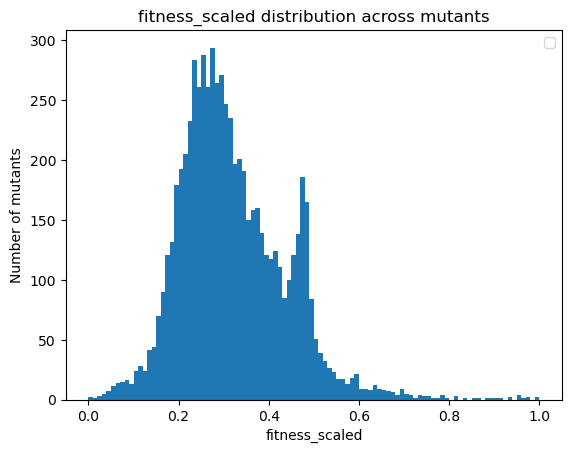

Number of NA: 0
WT not found in mutation column
Number of variants: 6810
Number of fitness_binary = 1: 77


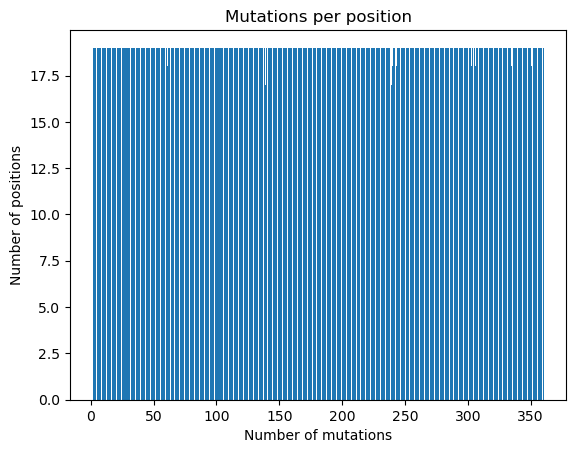

In [6]:
dataset_name = 'brenan'  # Provide the dataset sheet name
fitness_column = 'DMS_SCH'  # Provide the fitness column name
sheet_name = 'MAPK1'  # Provide the sheet name
cutoff_value = 2.5  # Provide the cutoff value

process_dataset(dataset_name, sheet_name, fitness_column, cutoff_value)

In [7]:
# List of settings
settings = [
    [ 'dms_adrb2', 'DMS_0.625', 2.8, 2,  'jones'],
    [ 'dms_bla', 'DMS_amp_2500_(b)', 0.01, 2, 'stiffler' ],
    [ 'dms_env', 'DMS', 0.1, 2, 'haddox' ],
    [ 'dms_ha_h1', 'DMS', 0.1, 2, 'doud' ],
    [ 'dms_ha_h3', 'DMS', 0.1, 2, 'lee' ],
    [ 'dms_infa', 'DMS_min', 0.98, 1, 'kelsic' ],
    [ 'dms_mapk1', 'DMS_SCH', 2.5, 1, 'brenan' ],
    [ 'dms_p53', 'DMS_null_etoposide', 1, 2, 'giacomelli' ],
    [ 'dms_pafa', 'DMS_kcat_km', 2300000, 1, 'markin' ],
]

for namespace, dms_name, cutoff, k_cutoff, dataset_name in settings:
    # Read the CSV file
    df = pd.read_csv(f'dms/{namespace}_esm.csv', delimiter=',')
    
    # Filter based on ESM_vote >= k_cutoff
    filtered_df = df[df['ESM_vote'] >= k_cutoff]

    # Filter based on dms_name not being NaN
    filtered_df = filtered_df[filtered_df[dms_name].notna()]  # Use dms_name variable
    
    # Save the filtered DataFrame to a CSV file
    filtered_df.to_csv(f'hie_temp/{dataset_name}.csv', index=False)
    
    # Calculate statistics
    total_above_k_cutoff = len(filtered_df)
    above_cutoff_and_k_cutoff = len(filtered_df[filtered_df[dms_name] >= cutoff])  # Use dms_name variable
    
    # Print statistics
    print(f'{dataset_name}:')
    print(f'Total values above k_cutoff: {total_above_k_cutoff}')
    print(f'Values above k_cutoff and cutoff: {above_cutoff_and_k_cutoff}')
    print('-' * 40)


jones:
Total values above k_cutoff: 9
Values above k_cutoff and cutoff: 2
----------------------------------------
stiffler:
Total values above k_cutoff: 10
Values above k_cutoff and cutoff: 4
----------------------------------------
haddox:
Total values above k_cutoff: 31
Values above k_cutoff and cutoff: 7
----------------------------------------
doud:
Total values above k_cutoff: 32
Values above k_cutoff and cutoff: 5
----------------------------------------
lee:
Total values above k_cutoff: 17
Values above k_cutoff and cutoff: 6
----------------------------------------
kelsic:
Total values above k_cutoff: 10
Values above k_cutoff and cutoff: 5
----------------------------------------
brenan:
Total values above k_cutoff: 13
Values above k_cutoff and cutoff: 1
----------------------------------------
giacomelli:
Total values above k_cutoff: 17
Values above k_cutoff and cutoff: 2
----------------------------------------
markin:
Total values above k_cutoff: 10
Values above k_cutoff and

In [7]:
def generate_single_aa_mutants_fasta(wt_sequence, output_file):
    aa_alphabet = "ACDEFGHIKLMNPQRSTVWY"

    records = []
    
    # Add the wild-type sequence as the first record
    wt_record = SeqRecord(Seq(wt_sequence), id="WT", description="Wild-type sequence")
    records.append(wt_record)
    
    for i, wt_aa in enumerate(wt_sequence):
        for mutant_aa in aa_alphabet:
            if mutant_aa != wt_aa:
                mutant_sequence = wt_sequence[:i] + mutant_aa + wt_sequence[i+1:]
                variant = f'{wt_aa}{i+1}{mutant_aa}'
                record = SeqRecord(Seq(mutant_sequence), id=variant, description="")
                records.append(record)

    with open(output_file, "w") as handle:
        SeqIO.write(records, handle, "fasta")
    
    # Print the number of records
    num_records = len(records)
    print(f"Number of records: {num_records}")


In [9]:
# Example usage
wt_sequence = "MNTINIAKNDFSDIELAAIPFNTLADHYGERLAREQLALEHESYEMGEARFRKMFERQLKAGEVADNAAAKPLITTLLPKMIARINDWFEEVKAKRGKRPTAFQFLQEIKPEAVAYITIKTTLACLTSADNTTVQAVASAIGRAIEDEARFGRIRDLEAKHFKKNVEEQLNKRVGHVYKKAFMQVVEADMLSKGLLGGEAWSSWHKEDSIHVGVRCIEMLIESTGMVSLHRQNAGVVGQDSETIELAPEYAEAIATRAGALAGISPMFQPCVVPPKPWTGITGGGYWANGRRPLALVRTHSKKALMRYEDVYMPEVYKAINIAQNTAWKINKKVLAVANVITKWKHCPVEDIPAIEREELPMKPEDIDMNPEALTAWKRAAAAVYRKDKARKSRRISLEFMLEQANKFANHKAIWFPYNMDWRGRVYAVSMFNPQGNDMTKGLLTLAKGKPIGKEGYYWLKIHGANCAGVDKVPFPERIKFIEENHENIMACAKSPLENTWWAEQDSPFCFLAFCFEYAGVQHHGLSYNCSLPLAFDGSCSGIQHFSAMLRDEVGGRAVNLLPSETVQDIYGIVAKKVNEILQADAINGTDNEVVTVTDENTGEISEKVKLGTKALAGQWLAYGVTRSVTKRSVMTLAYGSKEFGFRQQVLEDTIQPAIDSGKGLMFTQPNQAAGYMAKLIWESVSVTVVAAVEAMNWLKSAAKLLAAEVKDKKTGEILRKRCAVHWVTPDGFPVWQEYKKPIQTRLNLMFLGQFRLQPTINTNKDSEIDAHKQESGIAPNFVHSQDGSHLRKTVVWAHEKYGIESFALIHDSFGTIPADAANLFKAVRETMVDTYESCDVLADFYDQFADQLHESQLDKMPALPAKGNLNLRDILESDFAFA"
print(len(wt_sequence))
output_file = "wet_lab/t7_pol.fasta"
generate_single_aa_mutants_fasta(wt_sequence, output_file)

883
Number of records: 16778


/Users/matteodibernardo/miniconda3/envs/ML/lib/python3.10/site-packages/Bio/SeqRecord.py:215: ResourceWarning: unclosed file <_io.TextIOWrapper name='dataframes_VEP/brenan_WT.fasta' mode='rt' encoding='UTF-8'>
  annotations = {}


In [10]:
# Example usage
wt_sequence = "VKVTVPDKNPPCPCCSTRLNSVLALIDHLKGSHGKRRVCFRCAKCGRENFNHHSTVCHFAKCKGPSEEKPPVGEWICEVCGRDFTTKIGLGQHKRLAHPMVRNQERIDASQPKETSNRGAHKKCWTKEEEELLARLEVQFEGHKNINKLIAEHITTKTNKQISDKRRQMTRKDKGEGGAAGKLGPDTGRGNHSQAKVGNNGLGGNQLPGGPAATKDKAGCHLDKEEGNRIAISQQKKGRLQGRYHKEIKRRLEEGVINTFTKAFKQLLECQEVQPLINKTAQDCFGLLESACHIRTALRGKNKKETQEKPTGGQCLKWMKKRAVKKGNYLRFQRLFHLDRGKLARIILDDIECLSCDIAPSEIYSVFKARWETPGQFAGLGNFKSTGKADNKAFSDLITAKEIKKNVQEMSKGSAPGPDGIAIGDIKGMDPGYSRTAELFNLWLTSGEIPDMVRGCRTVLIPKSTQPERLKDINNWRPITIGSILLRLFSRIITARMTKACPLNPRQRGFIRAAGCSENLKLLQTIIRTAKSEHRPLGVVFVDIAKAFDTVSHQHILHVLQQRGVDPHIIGLVSNMYKDISTFVTTKKDTHTDKIQIRVGVKQGDPLSPLLFNLAMDPLLCKLEESGNGFHRGGHTITAMAFADDLVLLSDSWENMEKNIEILEAFCDLTGLKTQGQKCHGFYIKPTKDSYTVNNCAAWTIYGTPLNMINPGDSEKYLGLQIDPWTGIARSNISSKLDSWLERINQAPLKPLQKLDILKTYTIPRLTYMVDHSEMKAGALEALDLQIRSAVKDWLHLPSCTCDAILYVSTKDGGLGVTKLAGLIPSIQARRLHRIAQSPDETMKAFLDKEQMEKQYAKLWVQAGGKREKIPSIWDALPTPVLLTTSDTLSEWEAPNPKSKYPRPCNWRRKEFEKWTKLQCQGRGIQNFKGDVISNNWIQNYRRIPHRKLLTAVQLRANVYPTREFLGRGRGDDCVKFCRHCEVDLETCGHIISYCPVTKEARIKRHNRICERLIEEAEKKDWVVFKEPHIRDAVKELFKPDLIFVKEDRALVVDVTVRFEATTTSLEEAAIEKVDKYKRLETEVRSLTNAKDVLFMGFPLGARGKWYQGNFKLLDMLGLSESRQVTVAKTLSTDALISSVDIVHMFASKARKMNLVTV"
print(len(wt_sequence))
output_file = "wet_lab/r2.fasta"
generate_single_aa_mutants_fasta(wt_sequence, output_file)

1158
Number of records: 22003


In [11]:
# Example usage
wt_sequence = "MKRKREDLTLWDAANVHKHKSMWYWWEYIRRKDMVNHEKTDCDVIQLLQSASVKKQKTQSDKFLTSFSVGIRPTKHQKRVLNEMLRVSNYTYNWCLWLVNEKGLKPHQFELQKIVCKTNANDVDPQYRMENDDWFFNNKMTSVKLTSCKNFCTSYKSAKSLKSKLKRPMSVSNIIQGSFCVPKLFIRHLSSKDVSTDNTNMQNRYICMMPDNFEKRSNPKERFLKLAKPITKIPPIDHDVKIVKRADGMFIMNIPCDPKYTRRNASNDTIEKRVCGIDPGGRTFATVYDPIDCCVFQVGIKEDKQYVISKLHNKIDHAHMHLTKAQNKKQQQAARERIVSLKKTHLKLKTFVDDIHLKLSSHLVKEYQYVALGKINVAQLVKTDRPKPLSKRAKRDLLYWQHYRFRQRLTHRTTNTECILDVQNEAYTSKTCGVCGTINKNLEKSETFYCDQCKYNTHRDVNGARNILLKSLRMFPFEKQQQ"
print(len(wt_sequence))
output_file = "wet_lab/fanzor.fasta"
generate_single_aa_mutants_fasta(wt_sequence, output_file)

482
Number of records: 9159


In [12]:
# Example usage
wt_sequence = "LNIEDEYRLHETSKEPDVSLGSTWLSDFPQAWAETGGMGLAVRQAPLIIPLKATSTPVSIKQYPMSQEARLGIKPHIQRLLDQGILVPCQSPWNTPLLPVKKPGTNDYRPVQDLREVNKRVEDIHPTVPNPYNLLSGLPPSHQWYTVLDLKDAFFCLRLHPTSQPLFAFEWRDPEMGISGQLTWTRLPQGFKNSPTLFNEALHRDLADFRIQHPDLILLQYVDDLLLAATSELDCQQGTRALLQTLGNLGYRASAKKAQICQKQVKYLGYLLKEGQRWLTEARKETVMGQPTPKTPRQLREFLGKAGFCRLFIPGFAEMAAPLYPLTKPGTLFNWGPDQQKAYQEIKQALLTAPALGLPDLTKPFELFVDEKQGYAKGVLTQKLGPWRRPVAYLSKKLDPVAAGWPPCLRMVAAIAVLTKDAGKLTMGQPLVILAPHAVEALVKQPPDRWLSNARMTHYQALLLDTDRVQFGPVVALNPATLLPLPEEGLQHNCLDILAEAHGTRPDLTDQPLPDADHTWYTDGSSLLQEGQRKAGAAVTTETEVIWAKALPAGTSAQRAELIALTQALKMAEGKKLNVYTDSRYAFATAHIHGEIYRRRGWLTSEGKEIKNKDEILALLKALFLPKRLSIIHCPGHQKGHSAEARGNRMADQAARKAAITETPDTSTLLIENSSP"
print(len(wt_sequence))
output_file = "wet_lab/mlv.fasta"
generate_single_aa_mutants_fasta(wt_sequence, output_file)

676
Number of records: 12845


In [8]:
# Example usage
wt_sequence = "MRALVVIRLSRVTDATTSPERQLESCQQLCAQRGWDVVGVAEDLDVSGAVDPFDRKRRPNLARWLAFEEQPFDVIVAYRVDRLTRSIRHLQQLVHWAEDHKKLVVSATEAHFDTTTPFAAVVIALMGTVAQMELEAIKERNRSAAHFNIRAGKYRGSLPPWGYLPTRVDGEWRLVPDPVQRERILEVYHRVVDNHEPLHLVAHDLNRRGVLSPKDYFAQLQGREPQGREWSATALKRSMISEAMLGYATLNGKTVRDDDGAPLVRAEPILTREQLEALRAELVKTSRAKPAVSTPSLLLRVLFCAVCGEPAYKFAGGGRKHPRYRCRSMGFPKHCGNGTVAMAEWDAFCEEQVLDLLGDAERLEKVWVAGSDSAVELAEVNAELVDLTSLIGSPAYRAGSPQREALDARIAALAARQEELEGLEARPSGWEWRETGQRFGDWWREQDTAAKNTWLRSMNVRLTFDVRGGLTRTIDFGDLQEYEQHLRLGSVVERLHTGMS"
print(len(wt_sequence))
output_file = "wet_lab/bxb1.fasta"
generate_single_aa_mutants_fasta(wt_sequence, output_file)

500
Number of records: 9501


In [13]:
# Example usage
wt_sequence = "MTVTDDYLANNVDYASGFKGPLPMPPSKHIAIVACMDARLDVYRMLGIKEGEAHVIRNAGCVVTDDVIRSLAISQRLLGTREIILLHHTDCGMLTFTDDDFKRAIQDETGIRPTWSPESYPDAVEDVRQSLRRIEVNPFVTKHTSLRGFVFDVATGKLNEVTPAAALEARKEAELAAATAEQ"
print(len(wt_sequence))
output_file = "wet_lab/ca.fasta"
generate_single_aa_mutants_fasta(wt_sequence, output_file)

182
Number of records: 3459
